<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Digital Wage Payment Prediction</h1> 
<h2 style="text-align: center;" markdown="2">An AIMS Masters project in Collaboration with the Global Centre on Digital Wages for Decent Work (ILO)</h2>


> *The widespread adoption of digital payments has become increasingly important. In light of this, the aim of this project is to investigate the probability of an individual receiving digital wages in Africa. To achieve this, a series of empirical comparative assessments of machine learning classification algorithms will be conducted. The objective is to determine the effectiveness of these algorithms in predicting digital wage payments. Therefore, this notebook forms part of a larger project that seeks to explore the potential of machine learning in addressing issues related to financial inclusion in Africa.*

<h1 style="text-align: center;" markdown="3">Algorithm 2 - Support Vector Machine Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 2: Demographic Feature Set </h2> 

# Table of Contents

[Introduction](#setup)  
[No Sample Weights](#noweights)    
[Sample Weights](#weights)  
[Cross-Validation and Parameter Tuning](#cross-validation)   
[SVM Summary](#summary)

# Introduction <a class="anchor" id="setup"></a>

We will now apply the Support Vector Machine classifier to the dataset. 

We start with loading our standard libraries and the data

In [1]:
%matplotlib inline

import os
import sys

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

from sklearn.svm import SVC

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_data_filepaths, 
                            split_features_labels_weights, 
                            load_data)

from features.process_features import get_vif, standardize


ALGORITHM_NAME = 'svm'
COUNTRY = 'dem_merged_dumvar'

TRAIN_PATH, TEST_PATH = get_data_filepaths(COUNTRY)

# No Sample Weights <a class="anchor" id="noweights"></a>

Now let's apply the SVM classifier to the dataset with no weights. One of the drawbacks of SVMs is that they are very slow to train on large datasets with large numbers of features. Some of the following cells may take a long time to run.

CPU times: user 2.44 s, sys: 30.6 ms, total: 2.47 s
Wall time: 2.47 s
CPU times: user 694 ms, sys: 0 ns, total: 694 ms
Wall time: 693 ms
In-sample score: 79.05%


/home/socrates/.local/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


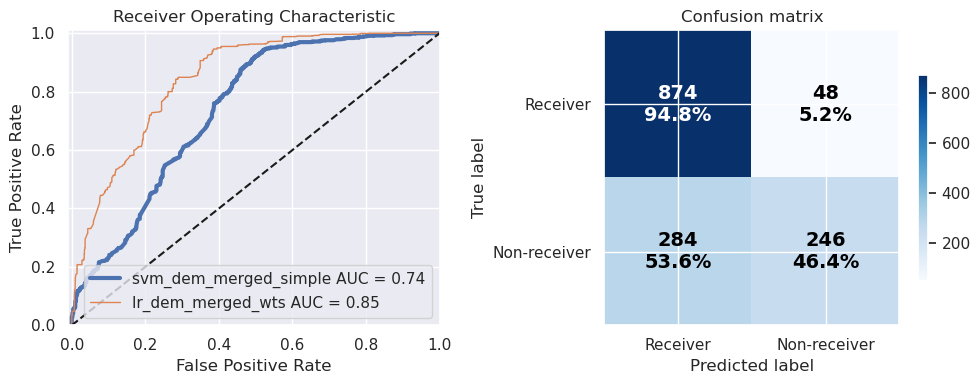

,svm_dem_merged_simple,lr_dem_merged_wts
accuracy,0.771350,0.809847
recall,0.947939,0.946640
precision,0.754750,0.782140
f1,0.840385,0.856563
cross_entropy,0.528589,0.450266
roc_auc,0.738946,0.845867
cohen_kappa,0.455177,0.469722


Actual digital wage rate: 58.40% 
Predicted digital wage rate: 72.32% 


In [2]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = SVC(probability=True)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# from sklearn.metrics import confusion_matrix
# confusion_matrix(y_test, y_pred, sample_weight=w_test)

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob,
                                    compare_models='lr_dem_merged_wts',
                                    store_model=True,
                                    model_name='dem_merged_simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

# Sample weights <a class="anchor" id="weights">

Next, we will incorporate the sample weights that came with the dataset, enabling us to generalize our model results to the overall population.

CPU times: user 15.5 s, sys: 13.2 ms, total: 15.5 s
Wall time: 15.5 s
CPU times: user 310 ms, sys: 226 µs, total: 311 ms
Wall time: 310 ms
In-sample score: 90.07%


/home/socrates/.local/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


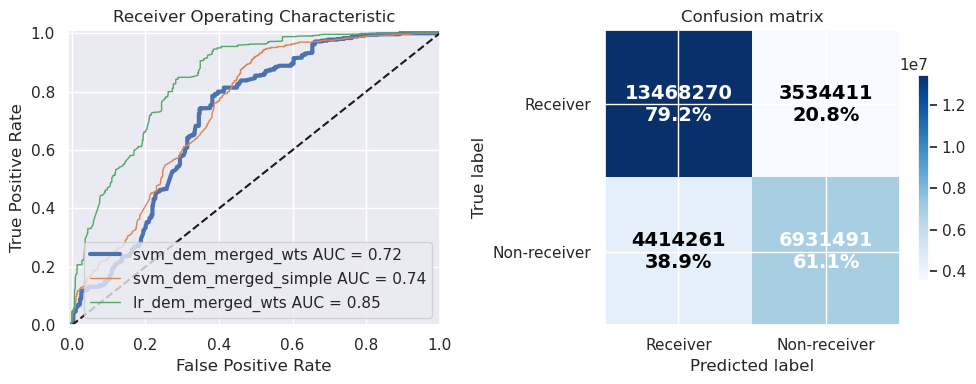

,svm_dem_merged_wts,svm_dem_merged_simple,lr_dem_merged_wts
accuracy,0.719608,0.771350,0.809847
recall,0.792126,0.947939,0.946640
precision,0.753152,0.754750,0.782140
f1,0.772148,0.840385,0.856563
cross_entropy,0.565200,0.528589,0.450266
roc_auc,0.715364,0.738946,0.845867
cohen_kappa,0.364478,0.455177,0.469722


Actual digital wage rate: 58.40% 
Predicted digital wage rate: 62.66% 


In [3]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# X_train, y_train, w_train = subsample(X_train, y_train, w_train)

# Fit the model
model = SVC(probability=True)
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['svm_dem_merged_simple', 'lr_dem_merged_wts'],
                                    store_model=True,
                                    model_name='dem_merged_wts', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

## Cross-validation and Parameter Tuning <a class="anchor" id="cross-validation"></a>

Now we do cross-validation when fitting the  model and try to find the best parameters through hyperparameter tuning.

In [4]:
from sklearn.model_selection import GridSearchCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# build the model
estimator = SVC(probability=True)
# parameters = {'C': 10**np.linspace(-4,1,6), 
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf', 'linear']}
svm_linear = {'C': [0.1, 1, 10, 100, 1000], 
              'kernel': ['linear']} 
svm_others = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001,'auto'], 
              'kernel': ['poly', 'rbf', 'sigmoid']}
parameters = [svm_linear, svm_others]
model = GridSearchCV(estimator, parameters, verbose=1, cv=5, n_jobs=-1)
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lr_dem_merged_wts', 'svm_dem_merged_simple', 'svm_dem_merged_wts'],
                                    store_model=True,
                                    model_name='dem_merged_wts_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

Fitting 5 folds for each of 95 candidates, totalling 475 fits


KeyboardInterrupt: 

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In-sample score: 90.07%


AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

# SVM Summary <a class="anchor" id="summary"></a>
We have covered the basic concepts of a SVM classifier, and applied it to our dataset. We also explored some techniques for analyzing the performance of our model as well as tuning parameters.


In [ ]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)